In [1]:
from scipy import stats
from scipy import linalg
import pandas as pd
import seaborn as sns
import scipy as sp
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
plt.style.use('seaborn-white')
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



In [2]:
Smarket = pd.read_csv('DataSets/Smarket.csv', usecols = range(1,10),parse_dates=True)


In [3]:
x_train = Smarket[0:sum(Smarket.Year<2005)][['Lag1','Lag2']]
y_train = Smarket[0:sum(Smarket.Year<2005)]['Direction']

x_test = Smarket[sum(Smarket.Year<2005):][['Lag1','Lag2']] # Data from 2005
y_test = Smarket[sum(Smarket.Year<2005):]['Direction'] # Data from 2005


Colormap

In [4]:
from matplotlib import colors
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

Plot functions

In [5]:
def plot_data(typ, X, y, y_pred, fig_index):
    splot = plt.subplot(1, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    alpha = 0.5

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', alpha=alpha,
             color='red')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '*', alpha=alpha,
             color='#990000')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', alpha=alpha,
             color='blue')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '*', alpha=alpha,
             color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = typ.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')
    
    #To make The Color difference visible
    
    Z[Z < 0.5] -= 0.3
    Z[Z > 0.5] += 0.3
    
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))


    return splot

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color, edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'blue')


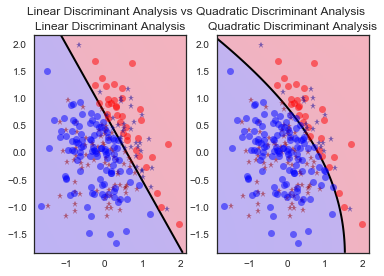

In [6]:
# With test Data
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(solver='svd', store_covariance=True)
y_LDA = lda.fit(x_train, y_train).predict(x_test)

# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis(store_covariances=True)
y_QDA = qda.fit(x_train, y_train).predict(x_test)

x_test = x_test.values
y_test = y_test.values

y_test[y_test == 'Up'] = 1
y_test[y_test == 'Down'] = 0
y_test = y_test.astype(np.int)

y_LDA[y_LDA == 'Up'] = 1
y_LDA[y_LDA == 'Down'] = 0
y_LDA = y_LDA.astype(np.int)

y_QDA[y_QDA == 'Up'] = 1
y_QDA[y_QDA == 'Down'] = 0
y_QDA = y_QDA.astype(np.int)

splot = plot_data(lda, x_test, y_test, y_LDA, fig_index=1)
# plot_lda_cov(lda, splot)
plt.axis('tight')

splot = plot_data(qda, x_test, y_test, y_QDA, fig_index=2)
# plot_qda_cov(qda, splot)
plt.axis('tight')

plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis')
plt.show()